Loaded: (19689, 10)
Candidate features: ['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield', 'Rainfall_per_Area', 'Fertilizer_per_Area', 'Pesticide_per_Area']
Train: (15751, 12) Test: (3938, 12)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2155
[LightGBM] [Info] Number of data points in the train set: 15751, number of used features: 12
[LightGBM] [Info] Start training from score 80.138340
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 170.706	valid's rmse: 303.81
[200]	train's rmse: 123.765	valid's rmse: 284.241
[300]	train's rmse: 99.9776	valid's rmse: 281.159
[400]	train's rmse: 83.5067	valid's rmse: 278.566
[500]	train's rmse: 70.255	valid's rmse: 275.381
[600]	train's rmse: 59.6623	valid's rmse: 274.563
[700]	train's rmse: 50.9176	valid's rm

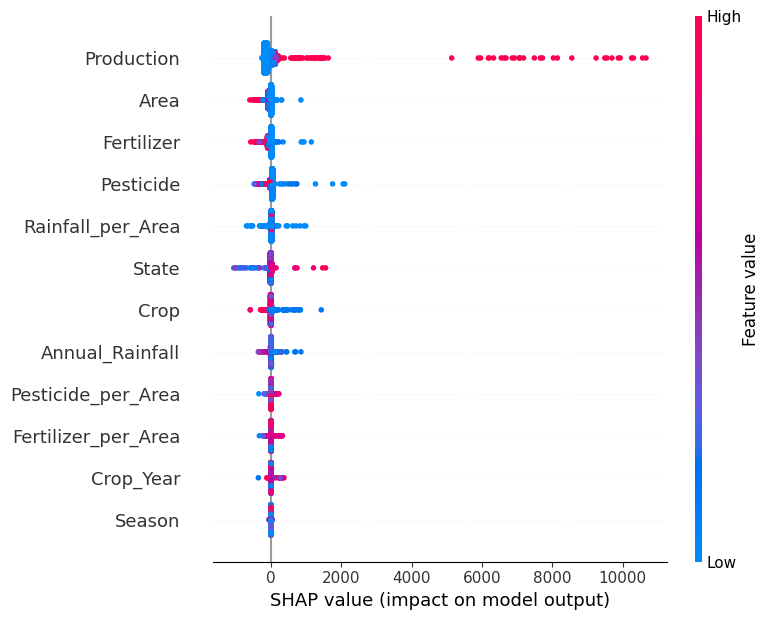

In [12]:
# =============================
# 1️⃣ Install & Import Libraries
# =============================
!pip install lightgbm joblib plotly streamlit shap --quiet

import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import joblib
import plotly.express as px
import os

# =============================
# 2️⃣ Load Dataset
# =============================
df = pd.read_csv("/content/crop_yield.csv")  # change if different filename
print("Loaded:", df.shape)
df.head()

# =============================
# 3️⃣ Basic Cleaning
# =============================
df = df.dropna()
df['Crop_Year'] = df['Crop_Year'].astype(int)
df['Rainfall_per_Area'] = df['Annual_Rainfall'] / (df['Area'] + 1e-6)
df['Fertilizer_per_Area'] = df['Fertilizer'] / (df['Area'] + 1e-6)
df['Pesticide_per_Area'] = df['Pesticide'] / (df['Area'] + 1e-6)

print("Candidate features:", df.columns.tolist())

# =============================
# 4️⃣ Encode Categorical Features
# =============================
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in ['Crop', 'Season', 'State']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

os.makedirs("model_artifacts", exist_ok=True)
joblib.dump(encoders, "model_artifacts/encoders.joblib")

# =============================
# 5️⃣ Define Features & Target
# =============================
X = df.drop(columns=['Yield'])
y = df['Yield']

# =============================
# 6️⃣ Train-Test Split
# =============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape} Test: {X_test.shape}")

# =============================
# 7️⃣ LightGBM Model
# =============================
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

# ✅ Updated training call with callback API
bst = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)
    ]
)

# =============================
# 8️⃣ Save Model
# =============================
joblib.dump(bst, "model_artifacts/crop_yield_lgbm.pkl")
print("Model saved to model_artifacts/crop_yield_lgbm.pkl")

# =============================
# 9️⃣ Evaluate
# =============================
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = bst.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# =============================
# 🔟 SHAP Explainability
# =============================
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, show=False)
print("SHAP summary plot generated.")



In [21]:
!npm install -g localtunnel
!streamlit run dashboard.py --server.port 8501 &>/content/logs.txt & npx localtunnel --port 8501


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
changed 22 packages in 2s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴your url is: https://odd-maps-crash.loca.lt
^C
